In [1]:
import Pkg
Pkg.activate("..")

  Activating project at `~/unsupervised_aav2`


In [2]:
using CSV, DataFrames, JLD2, StringDistances, PyPlot

In [3]:
data = CSV.read("library_w_selection_scores.csv", DataFrame)

Row,Column1,nt_seq,EK266_GAS1_p1_rep1a_plasmid,EK266_GAS1_p1_rep1b_plasmid,EK269_GAS1_p1_rep1a_plasmid_x,EK269_GAS1_p1_rep1b_plasmid_x,EK269_GAS1_p1_rep1c_plasmid_x,EK269_GAS1_p1_rep1d_plasmid_x,EK269_GAS1_v3_rep1a_virus_x,EK269_GAS1_v3_rep1b_virus_x,EK269_GAS1_v3_rep1c_virus_x,EK269_GAS1_v3_rep1d_virus_x,EK269_GAS1_v4_rep2a_virus_x,EK269_GAS1_v4_rep2b_virus_x,EK269_GAS1_v4_rep2c_virus_x,EK269_GAS1_v4_rep2d_virus_x,EK269_GAS1_v5_rep3a_virus_x,EK269_GAS1_v5_rep3b_virus_x,EK269_GAS1_v5_rep3c_virus,EK269_GAS1_v5_rep3d_virus,aa_x,category_x,chip_x,control_x,is_wt_aa_x,is_wt_nt_x,mask_x,mut_x,rep_i,rep_original_x,rep_total_x,EK269_GAS1_p1_rep1a_plasmid_y,EK269_GAS1_p1_rep1b_plasmid_y,EK269_GAS1_p1_rep1c_plasmid_y,EK269_GAS1_p1_rep1d_plasmid_y,EK269_GAS1_v3_rep1a_virus_y,EK269_GAS1_v3_rep1b_virus_y,EK269_GAS1_v3_rep1c_virus_y,EK269_GAS1_v3_rep1d_virus_y,EK269_GAS1_v4_rep2a_virus_y,EK269_GAS1_v4_rep2b_virus_y,EK269_GAS1_v4_rep2c_virus_y,EK269_GAS1_v4_rep2d_virus_y,EK269_GAS1_v5_rep3a_virus_y,EK269_GAS1_v5_rep3b_virus_y,aa_y,category_y,chip_y,control_y,is_wt_aa_y,is_wt_nt_y,mask_y,mut_y,rep_original_y,rep_total_y,GAS1_plasmid_N,GAS1_virus_N,GAS1_plasmid_F,GAS1_virus_F,GAS1_virus_S
,Int64,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,String,String,Int64,Int64,Int64,Int64,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,String,String,Int64,Int64,Int64,Int64,String,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64?
1,0,GACGAGGACGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGTATGGTTCTGTATCTACCAACCTCCAGGATAACGGCAACAACGATAGA,4,7,6,8,8,8,16,17,16,12,17,18,19,8,21,16,10,20,DEDEIRTTNPVATEQYGSVSTNLQDnGnNdR,rnn_designed_plus_rand_train_walked,1,0,0,0,__D_____________________Dn_n_d_,5,1,1,1,13,89,51,47,176,47,53,211,78,188,84,29,45,42,DEDEIRTTNPVATEQYGSVSTNLQDnGnNdR,rnn_designed_plus_rand_train_walked,1,0,0,0,__D_____________________Dn_n_d_,5,1,1,230,1143,3.47247e-6,5.1631e-6,0.572274
2,1,GACGAGGACGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGTATGGTGCGGTATCTACCAACCTCCAGGGCGACGGCAACGATAGA,23,11,11,12,13,13,36,47,34,50,41,51,25,20,27,36,42,47,DEDEIRTTNPVATEQYGAVSTNLQGdGNdR,rnn_designed_plus_rand_train_walked,1,0,0,0,__D______________A______Gd__d_,5,1,1,1,29,129,100,63,439,131,130,563,269,513,270,98,88,85,DEDEIRTTNPVATEQYGAVSTNLQGdGNdR,rnn_designed_plus_rand_train_walked,1,0,0,0,__D______________A______Gd__d_,5,1,1,370,3042,5.58615e-6,1.37412e-5,1.29858
3,2,GACGAAGAGGAAATCGCTACAACCAATCCCGTGGCTACGGAGCAGTATGGTTCTGTATCTACCAACCTCCAGCACGACGGCGATGAAAGA,10,16,12,9,14,11,14,12,8,12,44,53,36,42,13,14,18,20,DEEEIATTNPVATEQYGSVSTNLQHdGDeR,rnn_designed_plus_rand_train_walked,1,0,0,0,_____A__________________Hd_De_,5,1,1,1,27,121,91,65,171,66,50,176,356,648,338,128,46,42,DEEEIATTNPVATEQYGSVSTNLQHdGDeR,rnn_designed_plus_rand_train_walked,1,0,0,0,_____A__________________Hd_De_,5,1,1,350,2307,5.2842e-6,1.04211e-5,0.979746
4,3,GACGAACACGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGTATGGTAATGTATCTACCAACCTCCAGGGCGGAGGCGACAACAGA,27,20,12,11,37,32,76,64,63,50,88,89,86,52,73,81,87,91,DEHEIRTTNPVATEQYGNVSTNLQGgGdNR,rnn_designed_plus_rand_train_walked,1,0,0,0,__H______________N______Gg_d__,5,1,1,1,66,288,243,190,830,244,238,979,651,1158,588,185,241,229,DEHEIRTTNPVATEQYGNVSTNLQGgGdNR,rnn_designed_plus_rand_train_walked,1,0,0,0,__H______________N______Gg_d__,5,1,1,879,6243,1.32709e-5,2.82006e-5,1.08746
5,4,GACGAACATGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGTATGGTTCTGTATCTACCAACCTCCAGCCGGGGGGCAACGATGGT,19,14,15,17,10,10,50,59,22,29,63,65,77,57,18,26,37,24,DEHEIRTTNPVATEQYGSVSTNLQpGGNDg,rnn_designed_plus_rand_train_walked,1,0,0,0,__H_____________________pG__Dg,5,1,1,1,36,172,122,97,552,188,157,616,487,845,457,146,75,76,DEHEIRTTNPVATEQYGSVSTNLQpGGNDg,rnn_designed_plus_rand_train_walked,1,0,0,0,__H_____________________pG__Dg,5,1,1,479,4126,7.2318e-6,1.86378e-5,1.3658
6,5,GACGAACACGAAATCAGGACAACCAATCCCGTGGCTACGGAGCAGTATGGTTCTGTATCTACCAACCTCCAGCATAACGGAAACGAAAGA,20,15,10,6,14,5,53,

# filtering out missing counts

In [4]:
size(data, 1)

243481

In [5]:
filter!(x-> !ismissing(x.GAS1_plasmid_N), data)
size(data, 1)

243481

In [6]:
filter!(x-> !ismissing(x.GAS1_virus_N), data)
size(data, 1)

243481

# filtering type of sequences, designed sequences separated from the ones used for training

In [7]:
labels = unique(data.category_x) 
labels .|> println;

rnn_designed_plus_rand_train_walked
rnn_designed_plus_rand_train_seed
rnn_rand_doubles_plus_singles_walked
rnn_rand_doubles_plus_singles_seed
rnn_standard_walked
rnn_standard_seed
cnn_designed_plus_rand_train_walked
cnn_designed_plus_rand_train_seed
cnn_rand_doubles_plus_single_walked
cnn_rand_doubles_plus_single_seed
cnn_standard_walked
cnn_standard_seed
lr_designed_plus_rand_train_walked
lr_designed_plus_rand_train_seed
lr_rand_doubles_plus_single_walked
lr_rand_doubles_plus_single_seed
lr_standard_walked
lr_standard_seed
previous_chip_viable
previous_chip_nonviable
stop
singles
wild_type
random_doubles


In [8]:
training_labels = ["wild_type", "singles", "random_doubles", "previous_chip_viable", "previous_chip_nonviable"]
generated_labels = [
    "rnn_designed_plus_rand_train_walked",
    "rnn_designed_plus_rand_train_seed",
    "rnn_rand_doubles_plus_singles_walked",
    "rnn_rand_doubles_plus_singles_seed",
    "rnn_standard_walked",
    "rnn_standard_seed",
    "cnn_designed_plus_rand_train_walked",
    "cnn_designed_plus_rand_train_seed",
    "cnn_rand_doubles_plus_single_walked",
    "cnn_rand_doubles_plus_single_seed",
    "cnn_standard_walked",
    "cnn_standard_seed",
    "lr_designed_plus_rand_train_walked",
    "lr_designed_plus_rand_train_seed",
    "lr_rand_doubles_plus_single_walked",
    "lr_rand_doubles_plus_single_seed",
    "lr_standard_walked",
    "lr_standard_seed"
]

18-element Vector{String}:
 "rnn_designed_plus_rand_train_walked"
 "rnn_designed_plus_rand_train_seed"
 "rnn_rand_doubles_plus_singles_walked"
 "rnn_rand_doubles_plus_singles_seed"
 "rnn_standard_walked"
 "rnn_standard_seed"
 "cnn_designed_plus_rand_train_walked"
 "cnn_designed_plus_rand_train_seed"
 "cnn_rand_doubles_plus_single_walked"
 "cnn_rand_doubles_plus_single_seed"
 "cnn_standard_walked"
 "cnn_standard_seed"
 "lr_designed_plus_rand_train_walked"
 "lr_designed_plus_rand_train_seed"
 "lr_rand_doubles_plus_single_walked"
 "lr_rand_doubles_plus_single_seed"
 "lr_standard_walked"
 "lr_standard_seed"

In [9]:
data_train = filter(x->x.category_x in training_labels, data)
data_generated = filter(x->x.category_x in generated_labels, data);

In [10]:
size(data_train, 1) + size(data_generated, 1) +  sum(data.category_x .== "stop") == size(data, 1)

true

In [11]:
data_experiment3 = filter(x->x.category_x in generated_labels, data);

# separate single mutations

In [12]:
wt_idx = findall(data_train.is_wt_aa_x .== 1)
wt_aa = data_train.aa_x[wt_idx] |> unique |> x->x[1] 

"DEEEIRTTNPVATEQYGSVSTNLQRGNR"

In [13]:
single_mut_idx = findall(data_train.mut_x .<=1)

4257-element Vector{Int64}:
   244
   245
   246
   475
   476
   477
   574
   575
   576
   829
   830
   831
   874
     ⋮
 10141
 10142
 10143
 10144
 10145
 10146
 10147
 10148
 10149
 10150
 10151
 10152

In [14]:
setdiff(wt_idx, single_mut_idx)

Int64[]

In [15]:
data_experiment1 = filter(x->x.mut_x .<= 1, data_train)
data_experiment2 = filter(x->x.mut_x .> 1, data_train);

# Distances

In [16]:
dist_exp1 = map(x->evaluate(Levenshtein(), x, wt_aa), data_experiment1.aa_x)
dist_exp2 = map(x->evaluate(Levenshtein(), x, wt_aa), data_experiment2.aa_x)
dist_exp3 = map(x->evaluate(Levenshtein(), x, wt_aa), data_experiment3.aa_x);

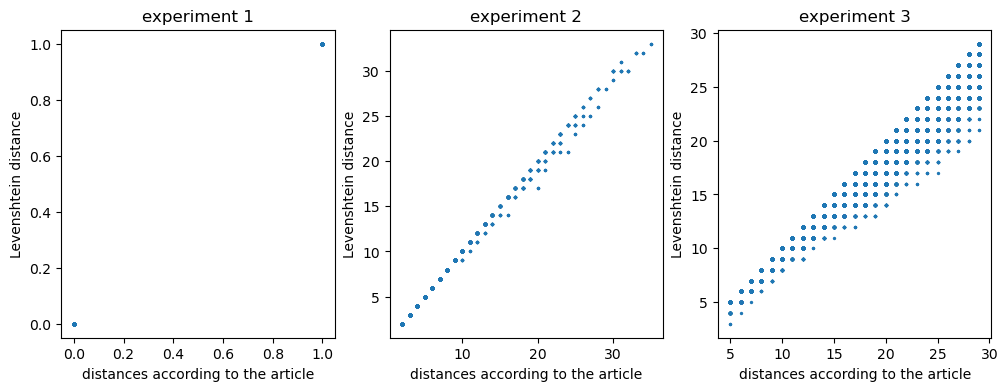

PyObject Text(0.5, 1.0, 'experiment 3')

In [17]:
fig, ax = subplots(1,3, figsize=(12,4))

ax[1].scatter(data_experiment1.mut_x, dist_exp1, s=2)
ax[1].set_xlabel("distances according to the article")
ax[1].set_ylabel("Levenshtein distance")
ax[1].set_title("experiment 1")

ax[2].scatter(data_experiment2.mut_x, dist_exp2, s=2)
ax[2].set_xlabel("distances according to the article")
ax[2].set_ylabel("Levenshtein distance")
ax[2].set_title("experiment 2")

ax[3].scatter(data_experiment3.mut_x, dist_exp3, s=2)
ax[3].set_xlabel("distances according to the article")
ax[3].set_ylabel("Levenshtein distance")
ax[3].set_title("experiment 3")

# merge counts

In [18]:
seq_counts_experiment1 = Dict{String, Vector{Int}}()
seq_counts_experiment2 = Dict{String, Vector{Int}}()
seq_counts_experiment3 = Dict{String, Vector{Int}}()

Dict{String, Vector{Int64}}()

In [19]:
function merge_counts!(data, seq_counts)
    @assert length(seq_counts) == 0
    for k in axes(data,1)
        uc_seq = uppercase(data.aa_x[k])
        if haskey(seq_counts, uc_seq)
            seq_counts[uc_seq][1] += data.GAS1_plasmid_N[k]
            seq_counts[uc_seq][2] += data.GAS1_virus_N[k]
        else
            push!(seq_counts, uc_seq => [data.GAS1_plasmid_N[k], data.GAS1_virus_N[k]])
        end
    end
    return
end         

merge_counts! (generic function with 1 method)

In [20]:
merge_counts!(data_experiment1, seq_counts_experiment1)
merge_counts!(data_experiment2, seq_counts_experiment2)
merge_counts!(data_experiment3, seq_counts_experiment3)

In [21]:
sum(data_experiment1.GAS1_plasmid_N) == sum(map(x->seq_counts_experiment1[x][1], collect(keys(seq_counts_experiment1))))

true

In [22]:
sum(data_experiment2.GAS1_plasmid_N) == sum(map(x->seq_counts_experiment2[x][1], collect(keys(seq_counts_experiment2))))

true

In [23]:
sum(data_experiment3.GAS1_plasmid_N) == sum(map(x->seq_counts_experiment3[x][1], collect(keys(seq_counts_experiment3))))

true

In [24]:
sum(data_experiment1.GAS1_virus_N) == sum(map(x->seq_counts_experiment1[x][2], collect(keys(seq_counts_experiment1))))

true

In [25]:
sum(data_experiment2.GAS1_virus_N) == sum(map(x->seq_counts_experiment2[x][2], collect(keys(seq_counts_experiment2))))

true

In [26]:
sum(data_experiment3.GAS1_virus_N) == sum(map(x->seq_counts_experiment3[x][2], collect(keys(seq_counts_experiment3))))

true

# merged data

In [27]:
sequences_experiment1 = collect(keys(seq_counts_experiment1))
sequences_experiment2 = collect(keys(seq_counts_experiment2))
sequences_experiment3 = collect(keys(seq_counts_experiment3));

In [28]:
counts_experiment1 = zeros(Int, length(sequences_experiment1), 2)
counts_experiment2 = zeros(Int, length(sequences_experiment2), 2)
counts_experiment3 = zeros(Int, length(sequences_experiment3), 2);

In [29]:
for (i, s) in pairs(sequences_experiment1)
    counts_experiment1[i, 1] = seq_counts_experiment1[s][1]
    counts_experiment1[i, 2] = seq_counts_experiment1[s][2]
end

In [30]:
for (i, s) in pairs(sequences_experiment2)
    counts_experiment2[i, 1] = seq_counts_experiment2[s][1]
    counts_experiment2[i, 2] = seq_counts_experiment2[s][2]
end

In [31]:
for (i, s) in pairs(sequences_experiment3)
    counts_experiment3[i, 1] = seq_counts_experiment3[s][1]
    counts_experiment3[i, 2] = seq_counts_experiment3[s][2]
end

In [ ]:
@save "../my_datadata_experiment1.jld2" sequences_experiment1 counts_experiment1 wt_aa

In [ ]:
@save "../my_datadata_experiment2.jld2" sequences_experiment2 counts_experiment2

In [ ]:
@save "../my_datadata_experiment3.jld2" sequences_experiment3 counts_experiment3